## Clustering of homes.
Read
https://scikit-learn.org/stable/modules/clustering.html#optics

https://en.wikipedia.org/wiki/OPTICS_algorithm


In [11]:
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from scipy.spatial import Delaunay
import pandas as pd
from shapely.geometry import LineString
import networkx as nx
import os
from tqdm import tqdm
import datetime

 
FOLDER_FOR_SHAPE_FILES = "shape_files_for_QGIS"
FOLDER_FOR_CLUSTER_PLOTS = "cluster_images"


In [2]:

# A sample of buildings, assumed to be buildings to place in ONE distribution grid

#buildings = 'SmallSample_OSMbuildings.geojson'
buildings = 'SLE_KenemaRadius_OSMBuildings.geojson'
print('Loading data...')
# Prepare building data - read as geodataframe
gdf = gp.read_file(buildings)
# Get the number of rows (points) in the GeoDataFrame
#no_points = gdf.shape[0]
print(gdf.head())
gdf.to_file(f"{FOLDER_FOR_SHAPE_FILES}/buildigs.shp")
print(f"CRS is {gdf.crs}.") #CRF: Cooordinate Reference System

gdfm=gdf.to_crs(epsg=32628) # See https://epsg.io/32628
print(gdfm.head())
print(f"CRS is {gdfm.crs}.")
gdf = gdfm

      osm_id  code    fclass  name  type  \
0  194636169  1500  building  None  None   
1  194636173  1500  building  None  None   
2  194636191  1500  building  None  None   
3  194636195  1500  building  None  None   
4  194636203  1500  building  None  None   

                                            geometry  
0  MULTIPOLYGON (((-11.36684 7.99306, -11.36680 7...  
1  MULTIPOLYGON (((-11.36671 7.99309, -11.36670 7...  
2  MULTIPOLYGON (((-11.36670 7.99296, -11.36668 7...  
3  MULTIPOLYGON (((-11.36686 7.99279, -11.36679 7...  
4  MULTIPOLYGON (((-11.36661 7.99295, -11.36657 7...  
CRS is EPSG:4326.
      osm_id  code    fclass  name  type  \
0  194636169  1500  building  None  None   
1  194636173  1500  building  None  None   
2  194636191  1500  building  None  None   
3  194636195  1500  building  None  None   
4  194636203  1500  building  None  None   

                                            geometry  
0  MULTIPOLYGON (((900638.291 885298.644, 900642....  
1  MULTIPOLY

In [3]:
# Get centroid points of building polygons

gdf['centroid'] = gdf['geometry'].centroid
# Break out lat and long into separate columns of GeoDataFrame
gdf['lon'] = gdf.centroid.x
gdf['lat'] = gdf.centroid.y
# Get lat and long columns from the GeoDataFrame and convert into a numpy array
coords = gdf.drop(['name', 'type', 'code', 'fclass', 'osm_id', 'geometry', 'centroid'], axis=1).to_numpy()
# You will get a warning.

In [9]:
def does_file_exist(directory, filename):
    file_path = os.path.join(directory, filename)
    return os.path.exists(file_path)

def delete_file(file_path):
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"> The file '{file_path}' has been deleted. Will be recreated.")
    else:
        print(f"> The file '{file_path}' does not exist. Will create a new one.")

def plot_bar_chart(dictionary):
    keys = list(dictionary.keys())
    values = list(dictionary.values())
    # Get the current date and time
    current_time = datetime.datetime.now()

    # Format the timestamp as a string (optional)
    timestamp_str = current_time.strftime("%Y%m%d_%H%M%S")    

    plt.bar(keys, values, color='blue')
    plt.xlabel('Epsilon Values')
    plt.ylabel('Total kilometers of cables')
    plt.title('Bar Chart for Dictionary Values')
    plt.savefig(f"simulation_comparions/cable_estimations_{timestamp_str}.png")
    plt.show()



# Haversine formula for kilometer distance between two lat/long points
def euclidean_distance(point1, point2):
    (x1, y1) = point1
    (x2, y2) = point2
    distance = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    return distance

## Run the Fit

In [5]:
def run_clustering_for_epsilon_distance(coords, epsilon_distance):
    clust = OPTICS(min_samples=10, xi=.05, min_cluster_size=.5)

    # Run the fit
    # 
    clust.fit(coords)
    labelsOp = clust.labels_
    labels = cluster_optics_dbscan(reachability=clust.reachability_,
                                    core_distances=clust.core_distances_,
                                    ordering=clust.ordering_, eps=epsilon_distance)
    num_clusters = len(set(labels))
    print(f"> There are {num_clusters} clusters for epsilon distance {epsilon_distance}.")



    numRepeats = int(num_clusters/7+2)
    colors = ['g', 'r', 'b', 'y','m', 'c','m','olive']*numRepeats

    # plot outliers
    plt.figure(figsize=(10, 10))

    plt.scatter(x=coords[labels == -1, 0], y=coords[labels == -1, 1],color='k', s=1, alpha=0.8)

    for klass, color in zip(range(0, num_clusters), colors):
        plt.scatter(x=coords[labels == klass, 0], y=coords[labels == klass, 1],color=color, s=5, alpha=0.8)
    plt.title(f"Clustering for epsilon distance of {epsilon_distance}")
    plt.savefig(f"{FOLDER_FOR_CLUSTER_PLOTS}/clusters_for_epsilon_of_{epsilon_distance}.png")

    return labels


In [6]:
def process_mst_for_cluster(cluster_to_work_with,labels,epsilon):
    # print(f"--Processing cluster {cluster_to_work_with}")
    cluster_to_points = {}
    for (point_index, cluster_assignment) in enumerate(labels):
        if cluster_assignment not in cluster_to_points:
            cluster_to_points[cluster_assignment] = [coords[point_index]]
        else:
            cluster_to_points[cluster_assignment].append(coords[point_index])



    coords_for_current_cluster = cluster_to_points[cluster_to_work_with] if cluster_to_work_with in cluster_to_points else []
    xcoords_of_cluster = [x for (x,y) in coords_for_current_cluster]
    ycoords_of_cluster = [y for (x,y) in coords_for_current_cluster]

    coords_not_in_current_cluster = []
    for cluster in cluster_to_points:
        if cluster != cluster_to_work_with:
            coords_not_in_current_cluster.extend(cluster_to_points[cluster])

    xcoords_outside_cluster = [x for (x,y) in coords_not_in_current_cluster]
    ycoords_outside_cluster = [y for (x,y) in coords_not_in_current_cluster]



    colors = ['g', 'r', 'b', 'y', 'c','m','olive','b','m']*20
    # plt.figure(figsize=(7, 7))
    #plot points in chosen cluster
    # plt.scatter(x=xcoords_of_cluster, y=ycoords_of_cluster,color='r', s=5, alpha=0.8)

    # plot outliers
    # plt.scatter(x=xcoords_outside_cluster, y=ycoords_outside_cluster,color='k', s=5, alpha=0.8)


    no_points = len(coords_for_current_cluster)

    #print('Calculating Delaunay triangulation and distance between Delaunay neighbours...')
    # Get Delauney triangulation of coordinates
    tri = Delaunay(coords_for_current_cluster)
    indices = tri.vertex_neighbor_vertices[0]
    indptr = tri.vertex_neighbor_vertices[1]

    # Instantiate dictionary to hold neighbors of each point & data-frame to hold distances between neighbours
    neighbors = {}
    locations = {}
    distances = pd.DataFrame(columns=["source", "dest", "distance"])
    

    # Get dictionary of neighbors of all points and a dictionary of locations of all points
    for k in range(0, no_points):
        neighbors[k] = indptr[indices[k]:indices[k+1]]
        locations[k] = coords_for_current_cluster[k][0], coords_for_current_cluster[k][1]

    # Get distances between all Delaunay neighbors
    dists = []
    for key, values in neighbors.items():
        for value in values:
            coord_1 = coords_for_current_cluster[key]
            coord_2 = coords_for_current_cluster[value]
            dist = euclidean_distance(coord_1, coord_2)
            dists.append({
                "source": key, 
                "dest": value, 
                "distance": dist
            })
    distances = pd.DataFrame(dists)
    #print(distances.head())



    # Plot Delaunay triangulation
    # plt.figure(figsize=(7, 7))
    # plt.title('Delaunay Triangulation of Homes')
    # plt.triplot(xcoords_of_cluster, ycoords_of_cluster, tri.simplices)
    # plt.xlabel('Longitude ')
    # plt.ylabel('Latitude ')
    # plt.plot(xcoords_of_cluster, ycoords_of_cluster, 'o')
    # axes = plt.gca()
    # axes.set_xlim([min(xcoords_of_cluster) - 0.001, max(xcoords_of_cluster) + 0.001])
    # axes.set_ylim([min(ycoords_of_cluster) - 0.001, max(ycoords_of_cluster) + 0.001])



    #print('Creating a graph from this information (edge weight = distance)...')
    G = nx.Graph()
    for index, row in distances.iterrows():
        G.add_edge(row['source'], row['dest'], weight=row['distance'])

    #print('Calculating the minimum spanning tree of the graph...')
    T = nx.minimum_spanning_tree(G)

    edges = T.edges(data=True)
    weights = [x[2]['weight'] for x in edges]
    total_dist = sum(weights)

    #print('Number of nodes (buildings) in the graph: ', T.number_of_nodes())
    #print('Number of edges in the minimum spanning tree: ', T.number_of_edges())
    # print('--Total distance of minimum spanning tree (in km): ', total_dist)

    # Create a geopandas dataframe and save as .shp

    # create an array of LineString from T
    lines = []
    for (i,edge) in enumerate(edges):
        point_a = coords_for_current_cluster[int(edge[0])]
        point_b = coords_for_current_cluster[int(edge[1])]
        line = LineString([point_a, point_b])
        lines.append(line)

    d = {'geometry':lines}
    mstDF = gp.GeoDataFrame(d, crs="EPSG:32628")
    shape_file_name = f"{FOLDER_FOR_SHAPE_FILES}/sierra_leone_epsilon_{epsilon}.shp"

    if does_file_exist(".",shape_file_name):
        #append 
        existing_shape = gp.read_file(shape_file_name)
        gdf_combined = gp.GeoDataFrame(pd.concat([existing_shape, mstDF]))
        gdf_combined.to_file(shape_file_name)
    else:
        mstDF.to_file(shape_file_name)
        
    # print('Plotting results:')
    # Plot Minimum Spanning Tree made from Delaunay Triangulation
    # plt.figure(figsize=(7, 7))
    # nx.draw_networkx(T, pos=locations, with_labels=False, node_size=15)
    # plt.title('Minimum Spanning Tree of Delaunay Graph \n (Edge Weight = Euclidean Distance)')
    # plt.xlabel('Longitude ')
    # plt.ylabel('Latitude')
    # axes = plt.gca()
    # axes.set_xlim([min(xcoords_of_cluster) - 0.001, max(xcoords_of_cluster) + 0.001])
    # axes.set_ylim([min(ycoords_of_cluster) - 0.001, max(ycoords_of_cluster) + 0.001])

    # Plot relative frequency of edge distances in minimum spanning tree
    # plt.figure(figsize=(10, 4))
    # plt.hist(weights, bins=200)
    # plt.yscale("log")
    # plt.ylabel('Number of edges of this distance')
    # plt.xlabel('Distance (km)')
    # plt.show()
    return total_dist



### Instructions

The following code runs the clustering algorithm for a set of epsilon distances

 1. Modify the `epsilons_to_test` list to include epsilon distances you want to test. Note that each simulation can take several minutes depending on your computer's memory and processor constraints. Running five simulations can take an hour! Running one to two epsilon values at a time is recommended.

2. Look for the "Finished running all epsilon clusterings." message to ensure the runs have finished
3. After the conclusion, you will have a set of output files that you can use to continue your analysis:
- For the shape files to load onto QGIS, look into the `shape_files_for_QGIS/` folder
- To visualize the clusters for different epsilon values, look into the `cluster_images/` folder
- To see a bar graph comparing runs, look at the `simulations_comparisons/` folder 

>Will test 1 different epsilon values.
>Starting clustering run 1 of 1 for epsilon 250...
The file 'shape_files_for_QGIS/sierra_leone_epsilon_250.shp' does not exist.
--There are 296 clusters for epsilon distance 250.


Processing clusters: 100%|██████████| 295/295 [10:00<00:00,  2.04s/cluster]


Total cable distance for epsilon 250 is 781813.1624371085 km.
Finished running all epsilon clusterings.


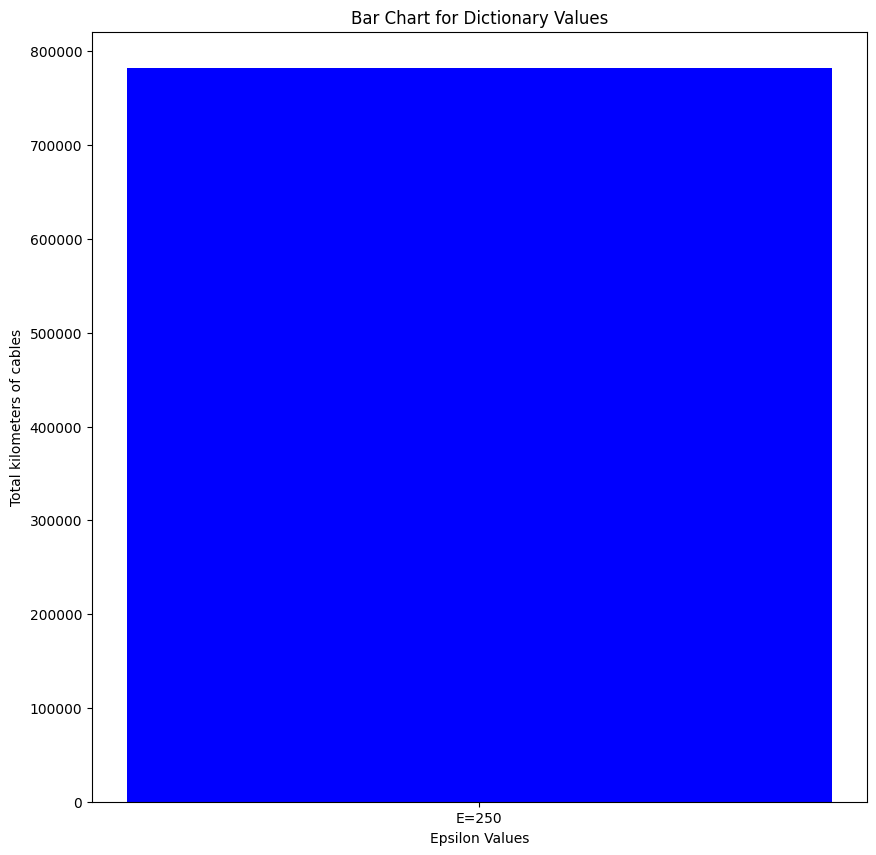

In [8]:
results = {}
epsilons_to_test = [250] # <-- change this to test different epsilon values
num_epsilons = len(epsilons_to_test)

print (f"> Will test {num_epsilons} epsilon value(s).")
for (epsilon_i,epsilon) in enumerate(epsilons_to_test):
    print(f"> Starting clustering run {epsilon_i + 1} of {num_epsilons} for epsilon value of {epsilon}...")
    shape_file_name = f"{FOLDER_FOR_SHAPE_FILES}/sierra_leone_epsilon_{epsilon}.shp"
    delete_file(shape_file_name)
    labels = run_clustering_for_epsilon_distance(coords, epsilon)
    num_clusters = len(set(labels))
    total_cable_distance = 0

    
    # for i in range(0,num_clusters - 1):
    #     total_cable_distance += process_mst_for_cluster(i,labels,epsilon)
    for i in tqdm(range(num_clusters - 1), desc="Processing clusters", unit="cluster"):
        total_cable_distance += process_mst_for_cluster(i, labels, epsilon)


    results[f"E={epsilon}"] = total_cable_distance
    print(f"Total cable distance for epsilon {epsilon} is {total_cable_distance} km.")
print("Finished running all epsilon clusterings.")
plot_bar_chart(results)
    